In [1]:
# from adnmtf import NMF, NTF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
import sys
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn import metrics

import adilsm.adilsm as ilsm

DATA_PATH = r'C:\Users\paul_\OneDrive\Pro\Galderma\Vevey\NEMO Phase 3\AD\EASI\data'
RESULTS_PATH = r'C:\Users\paul_\OneDrive\Pro\Galderma\Vevey\NEMO Phase 3\AD\EASI\results\ISM'

coucou


Data prep

In [2]:
df = pd.read_csv(DATA_PATH + r'\adeasi3_by_zone.csv', na_values=' ', index_col='USUBJID')

m0 = df.values[:,3:].astype(np.float_)

list_columns = df.columns[3:].to_list()
score_pref = ['Head And Neck', 'Limb, Lower', 'Limb, Upper', 'Trunk']
list_items = ['Area of Involvement', 'Erythema', 'Excoriation', 'Induration/Papulation', 'Lichenification']

n_scores = 4
n_items = [5, 5, 5, 5]

ISM workflow

In [3]:

n_embedding, n_themes = [4,6]
h4_updated, h4_updated_sparse, hhii_updated, w4_ism, h4_ism, q4_ism, tensor_score, m0_norm = ilsm.ism(m0, n_embedding, n_themes, n_scores, n_items, norm_m0=True, update_h4_ism=True,
                                                                    max_iter_integrate = 20, max_iter_mult=100, fast_mult_rules=False, sparsity_coeff=1)
print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated), 2))

condition number(4, 6) =  2.33


Save ISM results

In [4]:
# Save
df_h4_updated_sparse = ilsm.format_loadings(h4_updated_sparse, list_columns)
df_h4_updated_sparse.to_csv(RESULTS_PATH + r'\h4_updated_sparse.csv', sep=',', na_rep='.', index=True)

df_h4_updated = ilsm.format_loadings(h4_updated_sparse, list_columns)
df_h4_updated.to_csv(RESULTS_PATH + r'\h4_updated.csv', sep=',', na_rep='.', index=True)

df_q4_ism = pd.DataFrame(q4_ism)
df_q4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)]
df_q4_ism.insert(loc=0, column='score', value=score_pref)
df_q4_ism.to_csv(RESULTS_PATH + r'\q4_ism.csv', sep=',', na_rep='.', index=True)

cluster = np.argmax(w4_ism, axis=1)+1
# cluster = np.argmax(normalize(w4_ism, norm='max', axis=0), axis=1)+1

calinski_harabasz_score = metrics.calinski_harabasz_score(w4_ism, cluster)
print(f'calinski_harabasz_score: {calinski_harabasz_score}')
# silhouette_score = metrics.silhouette_score(w4_ism, cluster, metric='euclidean')
# print(f'Silhouette Score: {silhouette_score}')

df_w4_ism = pd.DataFrame(np.column_stack((w4_ism, cluster)))
df_w4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)] + ['nmf_cluster']

def calculate_value(row):
    for i in range(1, n_themes+1):
        if row.iloc[n_themes] == i:
            return row.iloc[i-1]

# Apply the function to each row
df_w4_ism['nmf_cluster_loading'] = df_w4_ism.apply(lambda row: calculate_value(row), axis=1)

for k in range(1,7):
    df_w4_ism['pred_'+str(k)] = df_w4_ism['theme_'+str(k)] / df_w4_ism[['theme_' +str(i) for i in range(1,6) if i != k]].max(axis=1)

df_w4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)] + ['nmf_cluster', 'nmf_cluster_loading'] +  ['pred_' + str(i) for i in range(1, n_themes + 1)]

df_w4_ism.insert(0, 'TRTP', df['TRTP'].to_list())
df_w4_ism.insert(0, 'ASEX', df['ASEX'].to_list())
df_w4_ism.insert(0, 'AGEGR1', df['AGEGR1'].to_list())
df_w4_ism.insert(loc=0, column='USUBJID', value=(df.index.to_list()))
df_w4_ism.set_index('USUBJID', inplace=True)
df_w4_ism.to_csv(RESULTS_PATH + r'\w4_ism.csv', sep=',', na_rep='.',index=True)

df_easy_by_time = pd.read_csv(DATA_PATH + r'\adeff_easi_no_dtype_no_doubles.csv', na_values=' ', index_col='USUBJID')
merged_df = pd.merge(df_w4_ism, df_easy_by_time, on='USUBJID')
merged_df.to_csv(RESULTS_PATH + r'\w4_ism_adeff_easi.csv', sep=',', na_rep='.',index=True)

print('condition number(w4_ism) = '  + str(np.linalg.cond(w4_ism)))

# Save the tensor
df_tensor_score = pd.DataFrame(data=tensor_score)
df_tensor_score.columns = [score_pref[j] + ':theme_' + str(i) for j in range(len(score_pref)) for i in range(1, int(tensor_score.shape[1]/n_scores) + 1)]
df_tensor_score.insert(loc=0, column='wise_id', value=(df.index.to_list()))
df_tensor_score.set_index('wise_id', inplace=True)
df_tensor_score.to_csv(RESULTS_PATH + r'\tensor_score.csv', sep=',', na_rep='.', index=True)

calinski_harabasz_score: 217.20840085533604
condition number(w4_ism) = 10.317792797819772


Additional tasks

calculate difference in %success between treatment and placebo as a function of predictor

In [ ]:
merged_df_W16 = merged_df[(merged_df['AVISIT'] == 'Week 16')].copy()
ncols = 3
nrows = int(np.ceil(n_themes/ncols))
irow = 0
icol = -1
xmin, xmax = 0, 1.1
ymin, ymax = .25, .55
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))

for k in range(1,7):
    merged_df_W16['PRED_'+str(k)] = merged_df_W16['theme_'+str(k)] / merged_df_W16[['theme_' +str(i) for i in range(1,6) if i != k]].max(axis=1)
    count_Y_Nemo = np.zeros(len(merged_df_W16))
    count_Y_Placebo = np.zeros(len(merged_df_W16))
    count_Nemo = np.ones(len(merged_df_W16))
    count_Placebo = np.ones(len(merged_df_W16))
    
    for i in range(len(merged_df_W16)):
        cutoff = merged_df_W16['PRED_'+str(k)].iloc[i]
        count_Y_Nemo[i] = merged_df_W16.loc[(merged_df_W16['PRED_'+str(k)] >= cutoff) & (merged_df_W16['TRTP'] == 'Nemolizumab') & (merged_df_W16['CRIT1FL'] == 'Y'), 'CRIT1FL'].count()
        count_Y_Placebo[i] = merged_df_W16.loc[(merged_df_W16['PRED_'+str(k)] >= cutoff) & (merged_df_W16['TRTP'] == 'Placebo') & (merged_df_W16['CRIT1FL'] == 'Y'), 'CRIT1FL'].count()
        count_Nemo[i] = merged_df_W16.loc[(merged_df_W16['PRED_'+str(k)] >= cutoff) & (merged_df_W16['TRTP'] == 'Nemolizumab'), 'CRIT1FL'].count()
        count_Placebo[i] = merged_df_W16.loc[(merged_df_W16['PRED_'+str(k)] >= cutoff) & (merged_df_W16['TRTP'] == 'Placebo'), 'CRIT1FL'].count()

    pct_respY_Nemo = np.divide(count_Y_Nemo, np.where(count_Nemo == 0, 1, count_Nemo))
    pct_respY_Nemo_err = np.sqrt(np.divide(pct_respY_Nemo * (1-pct_respY_Nemo), np.where(count_Nemo <= 1, 1, count_Nemo-1)))
    pct_respY_Placebo = np.divide(count_Y_Placebo, np.where(count_Placebo == 0, 1, count_Placebo))
    pct_respY_Placebo_err = np.sqrt(np.divide(pct_respY_Placebo * (1-pct_respY_Placebo), np.where(count_Placebo <= 1, 1, count_Placebo-1)))

    merged_df_W16['COUNT_NEMO_'+str(k)] = count_Nemo
    merged_df_W16['COUNT_PLACEBO_'+str(k)] = count_Placebo
    merged_df_W16['PCT_RESPY_NEMO_'+str(k)] = pct_respY_Nemo
    merged_df_W16['PCT_RESPY_NEMO_ERR_'+str(k)] = pct_respY_Nemo_err
    merged_df_W16['PCT_RESPY_PLACEBO_'+str(k)] = pct_respY_Placebo
    merged_df_W16['PCT_RESPY_PLACEBO_ERR_'+str(k)] = pct_respY_Placebo_err

    # Drop duplicates, sort and drop values with counts smaller than 10
    merged_df_W16_sorted = merged_df_W16.drop_duplicates(subset=['PRED_'+str(k)]).sort_values(by='PRED_'+str(k))
    merged_df_W16_sorted = merged_df_W16_sorted[(merged_df_W16_sorted['COUNT_NEMO_'+str(k)] > 10) & (merged_df_W16_sorted['COUNT_PLACEBO_'+str(k)] > 10)]

    # Superiority test
    super_test_delta = .05
    super_test = (merged_df_W16_sorted['PCT_RESPY_NEMO_'+str(k)] - merged_df_W16_sorted['PCT_RESPY_PLACEBO_'+str(k)] - super_test_delta).values
    super_test_err = np.sqrt((((merged_df_W16_sorted['COUNT_NEMO_'+str(k)]-1) * merged_df_W16_sorted['PCT_RESPY_NEMO_ERR_'+str(k)]**2 + \
                              (merged_df_W16_sorted['COUNT_PLACEBO_'+str(k)]-1) * merged_df_W16_sorted['PCT_RESPY_PLACEBO_ERR_'+str(k)]**2) / \
                              ((merged_df_W16_sorted['COUNT_NEMO_'+str(k)] + merged_df_W16_sorted['COUNT_PLACEBO_'+str(k)]-2))).values)
    
    merged_df_W16_sorted['SUPER_TEST_'+str(k)] = np.divide(super_test, super_test_err, out=np.zeros_like(super_test), where=super_test_err!=0)

    icol = icol+1

    merged_df_W16_sorted.plot.scatter(x='PRED_'+str(k), y='PCT_RESPY_NEMO_'+str(k), s=2, ax=axes[irow, icol], color='blue')
    merged_df_W16_sorted.plot.scatter(x='PRED_'+str(k), y='PCT_RESPY_PLACEBO_'+str(k), s=2, ax=axes[irow, icol], color='red')
    
    axes[irow, icol].fill_between(merged_df_W16_sorted['PRED_'+str(k)], merged_df_W16_sorted['PCT_RESPY_NEMO_'+str(k)]-merged_df_W16_sorted['PCT_RESPY_NEMO_ERR_'+str(k)], 
                                  merged_df_W16_sorted['PCT_RESPY_NEMO_'+str(k)]+merged_df_W16_sorted['PCT_RESPY_NEMO_ERR_'+str(k)], alpha=0.2, color='blue')
    axes[irow, icol].fill_between(merged_df_W16_sorted['PRED_'+str(k)], merged_df_W16_sorted['PCT_RESPY_PLACEBO_'+str(k)]-merged_df_W16_sorted['PCT_RESPY_PLACEBO_ERR_'+str(k)], 
                                  merged_df_W16_sorted['PCT_RESPY_PLACEBO_'+str(k)]+merged_df_W16_sorted['PCT_RESPY_PLACEBO_ERR_'+str(k)], alpha=0.2, color='red')
    axes[irow, icol].set_title('PCT_RESPY_'+str(k)+' by PRED'+str(k), fontdict={'fontsize': 8})
    axes[irow, icol].set_xlabel('PRED_'+str(k), fontdict={'fontsize': 6})
    axes[irow, icol].set_ylabel('PCT_RESPY_'+str(k), fontdict={'fontsize': 6})
    axes[irow, icol].axhline(y=merged_df_W16_sorted['PCT_RESPY_NEMO_'+str(k)].iloc[0], linestyle='--', color='grey')
    
    X = merged_df_W16_sorted['SUPER_TEST_'+str(k)].values
    Y = merged_df_W16_sorted['PRED_'+str(k)].values
    test_X = np.nonzero(X < 1.645)
    if len(test_X[0]) > 0:
        x = Y[test_X[0][0]]
        axes[irow, icol].axvline(x=x, linestyle='--', color='grey')
        axes[irow, icol].text(0.95, 0.95, "Cutoff="+str(round(x,2)), transform=axes[irow, icol].transAxes, \
             fontsize=8, ha="right", va="top")
    
    if icol==ncols-1:
        icol = -1
        irow+=1
    
for ax in axes.flat:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=6)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig_name=RESULTS_PATH + r'\predictors.png'
plt.savefig(fig_name, dpi=300)
plt.show()

Predict on phase2b data

In [ ]:
df2b = pd.read_csv(DATA_PATH + r'\easi2b_by_zone.csv', na_values=' ', index_col='USUBJID')

m02b = df2b.values[:,1:].astype(np.float_)
m02b_nan_0 = m02b.copy()

# create m0_weight with ones and zeros if not_missing/missing value
m02b_weight = np.where(np.isnan(m02b), 0, 1)
m02b_nan_0[np.isnan(m02b_nan_0)]=0

max_values = np.max(m02b_nan_0, axis=0)
# Replace maximum values equal to 0 with 1
m02b = np.divide(m02b, np.where(max_values == 0, 1, max_values))
m02b_nan_0 = np.divide(m02b_nan_0, np.where(max_values == 0, 1, max_values))

my_nmfmodel = NMF(n_components=n_themes, leverage=None, max_iter=200, tol=1.e-6, verbose=-1, random_state=0)
estimator_ = my_nmfmodel.fit_transform(m02b.copy(), h=h4_updated_sparse, update_h=False)
w42b = estimator_.w
h42b = estimator_.h
scale = np.linalg.norm(h4_updated_sparse, axis=0) / np.linalg.norm(h42b, axis=0)
h42b *= scale
w42b /= scale

cluster = np.argmax(w42b, axis=1)+1
# cluster = np.argmax(normalize(w4_ism, norm='max', axis=0), axis=1)+1

calinski_harabasz_score = metrics.calinski_harabasz_score(w42b, cluster)
print(f'calinski_harabasz_score: {calinski_harabasz_score}')
# silhouette_score = metrics.silhouette_score(w4_ism, cluster, metric='euclidean')
# print(f'Silhouette Score: {silhouette_score}')

df_w42b = pd.DataFrame(np.column_stack((w42b, cluster)))
df_w42b.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)]+ ['nmf_cluster']

def calculate_value(row):
    for i in range(1, n_themes+1):
        if row.iloc[n_themes] == i:
            return row.iloc[i-1]

# Apply the function to each row
df_w42b['nmf_cluster_loading'] = df_w42b.apply(lambda row: calculate_value(row), axis=1)
df_w42b.insert(0, 'TRTP', df2b['TRTP'].to_list())
df_w42b.insert(loc=0, column='USUBJID', value=(df2b.index.to_list()))
df_w42b.set_index('USUBJID', inplace=True)
df_w42b.to_csv(RESULTS_PATH + r'\w42b.csv', sep=',', na_rep='.',index=True)

df_easy2b_by_time = pd.read_csv(DATA_PATH + r'\easi2b_by_time.csv', na_values=' ', index_col='USUBJID')
merged_df = pd.merge(df_w42b, df_easy2b_by_time, on='USUBJID')
merged_df.to_csv(RESULTS_PATH + r'\w42b_easi2b_by_time.csv', sep=',', na_rep='.',index=True)


Figures

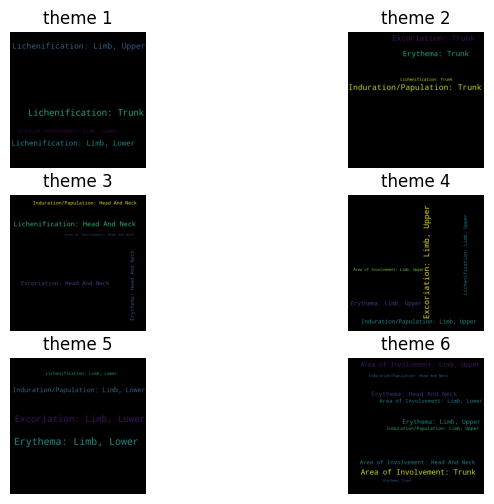

In [5]:
# Plot word clouds of the survey items
ncols = 2
nrows = int(np.ceil(n_themes/ncols))

irow = 0
icol = -1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated_sparse[df_h4_updated_sparse.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    icol = icol+1
    title = 'theme ' + str(i)
    axes[irow, icol].imshow(wc)
    axes[irow, icol].axis('off')
    axes[irow, icol].set_title(title)
    if icol==ncols-1:
        icol = -1
        irow+=1
 
fig_name=RESULTS_PATH + r'\word_clouds_items.png'
plt.savefig(fig_name, dpi=300)
plt.show()

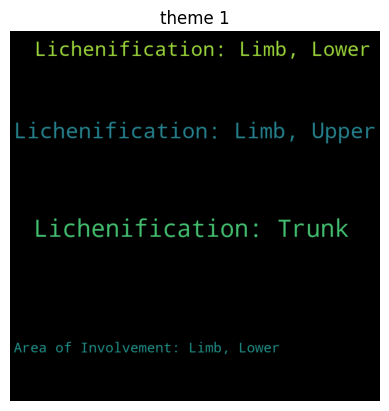

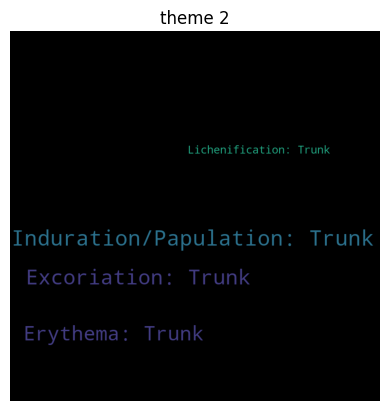

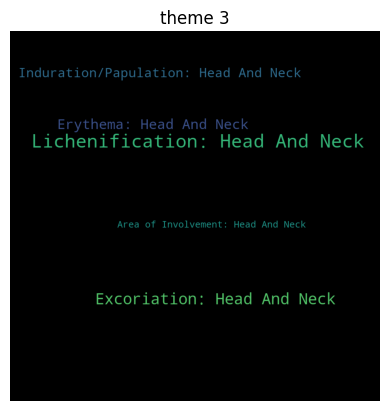

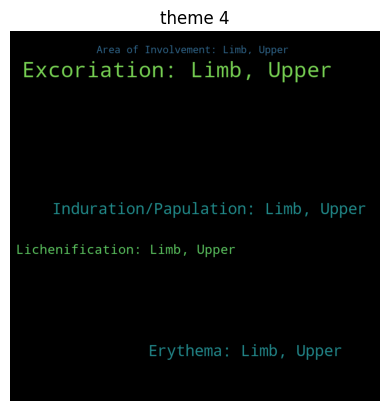

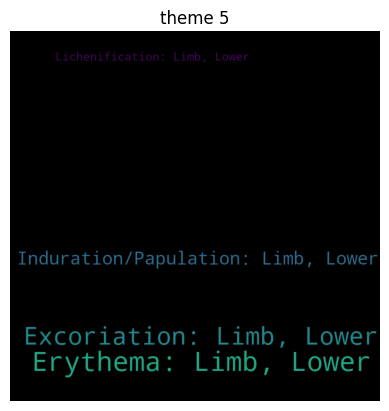

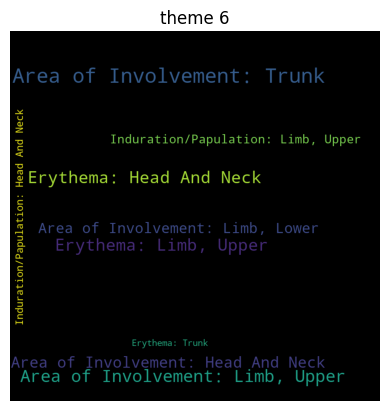

In [6]:
# Plot individual word clouds of the survey items

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated_sparse[df_h4_updated_sparse.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_items_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

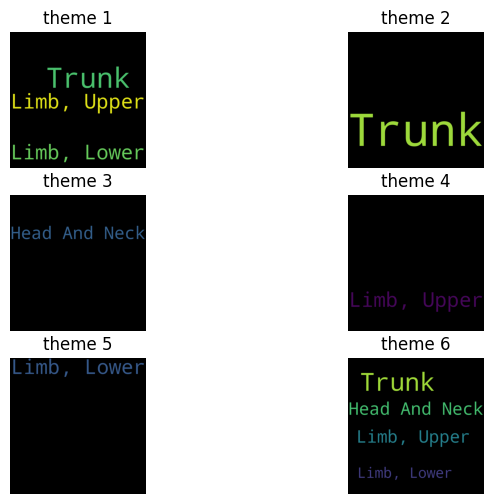

In [7]:
# Plot word clouds of the surveys
ncols = 2
nrows = int(np.ceil(n_themes/ncols))

irow = 0
icol = -1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i in range(1,n_themes+1):
    sub_df_q4_ism=df_q4_ism[df_q4_ism.columns[[0,i]]].set_index('score').T.to_dict('list')
    for k in sub_df_q4_ism:
        sub_df_q4_ism[k] = sub_df_q4_ism[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_q4_ism)

    icol = icol+1
    title = 'theme ' + str(i)
    axes[irow, icol].imshow(wc)
    axes[irow, icol].axis('off')
    axes[irow, icol].set_title(title)
    if icol==ncols-1:
        icol = -1
        irow+=1
 
fig_name=RESULTS_PATH + r'\word_clouds_surveys.png'
plt.savefig(fig_name, dpi=300)
plt.show()

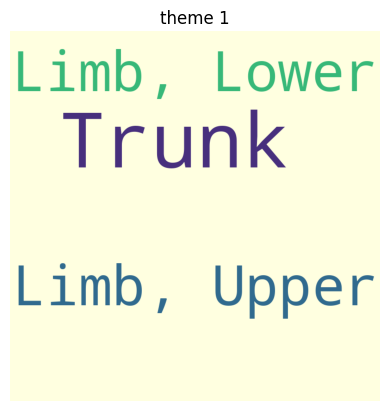

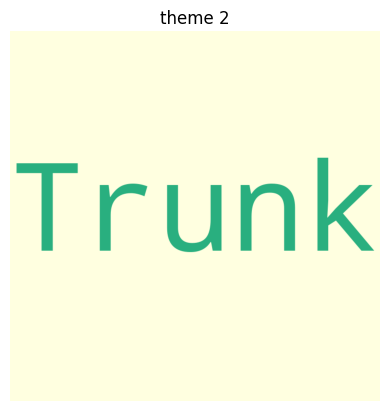

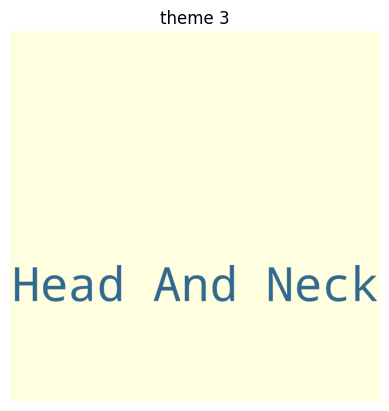

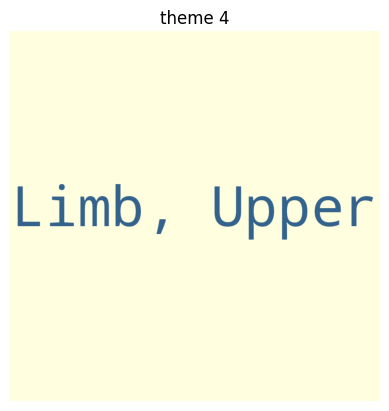

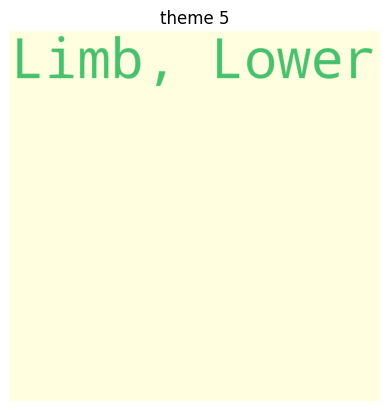

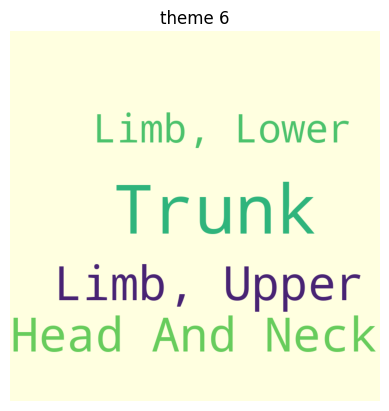

In [8]:
# Plot individual word clouds of the surveys

for i in range(1,n_themes+1):
    sub_df_q4_ism=df_q4_ism[df_q4_ism.columns[[0,i]]].set_index('score').T.to_dict('list')
    for k in sub_df_q4_ism:
        sub_df_q4_ism[k] = sub_df_q4_ism[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightyellow', relative_scaling=1).generate_from_frequencies(sub_df_q4_ism)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_surveys_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

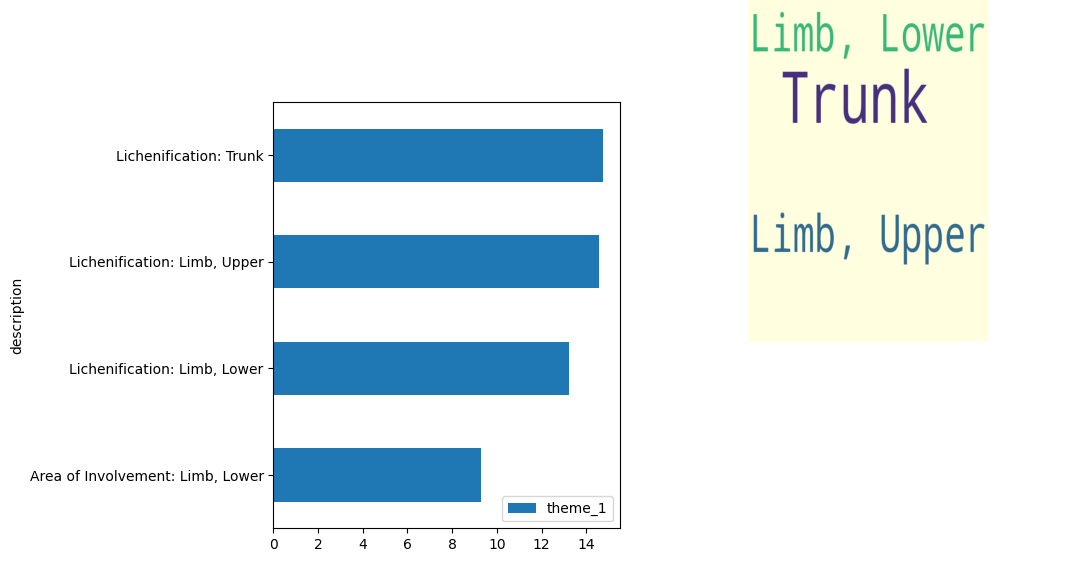

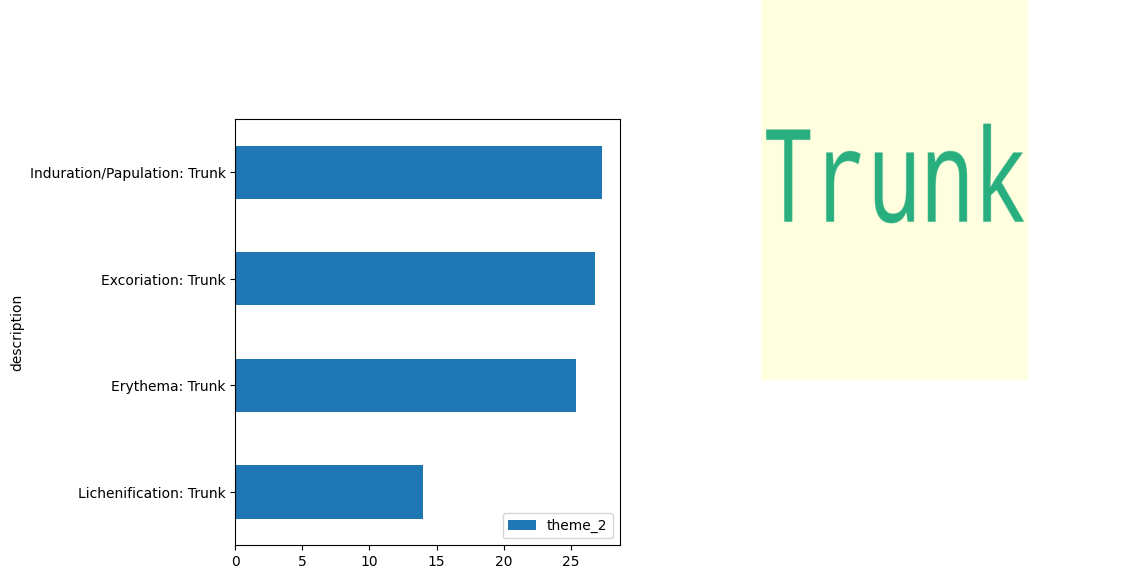

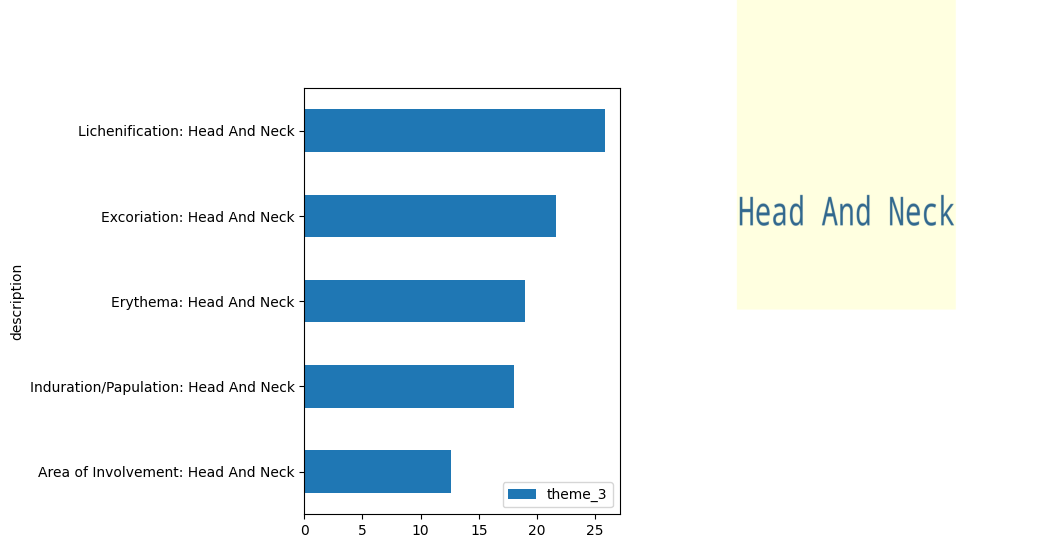

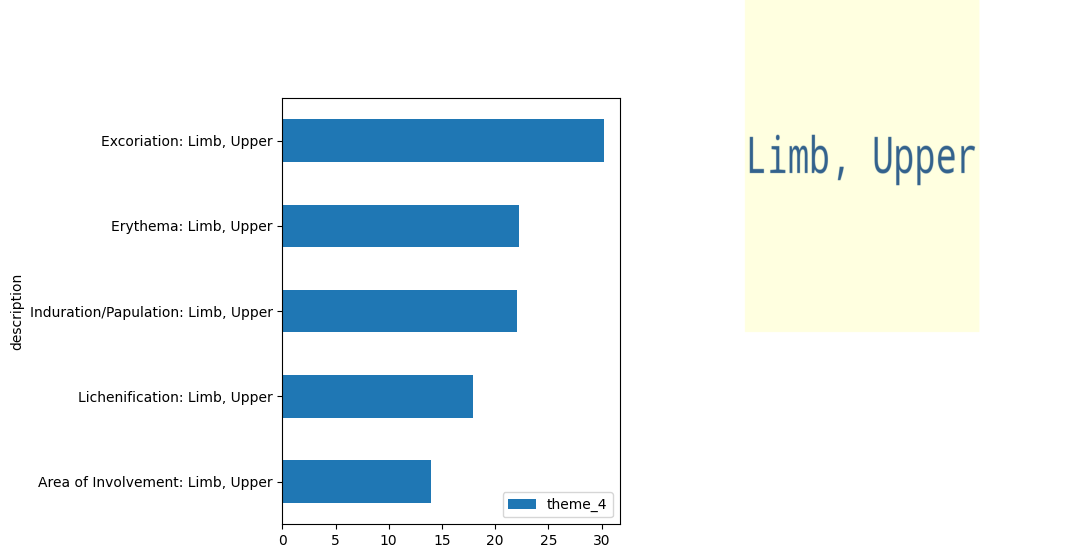

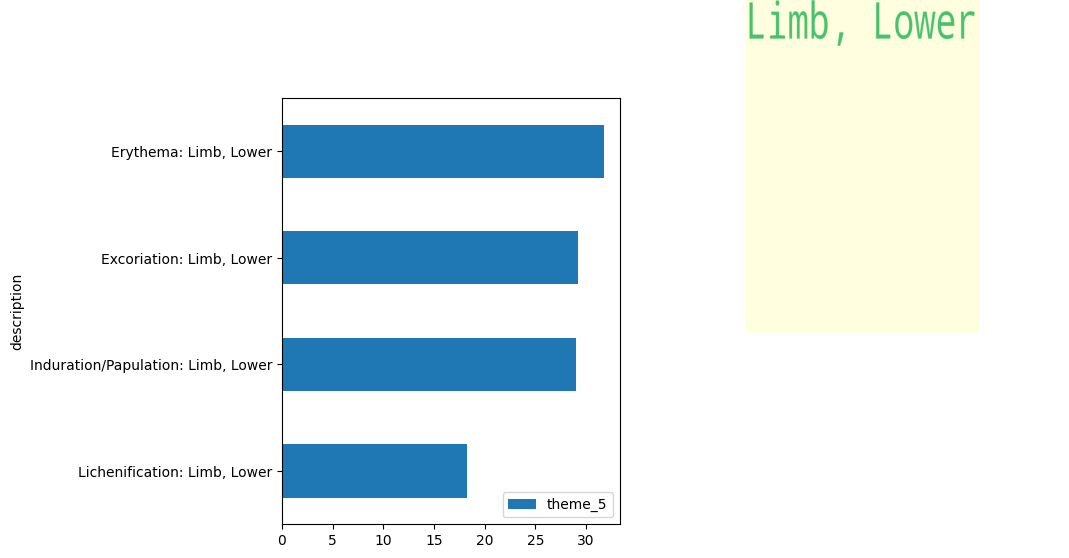

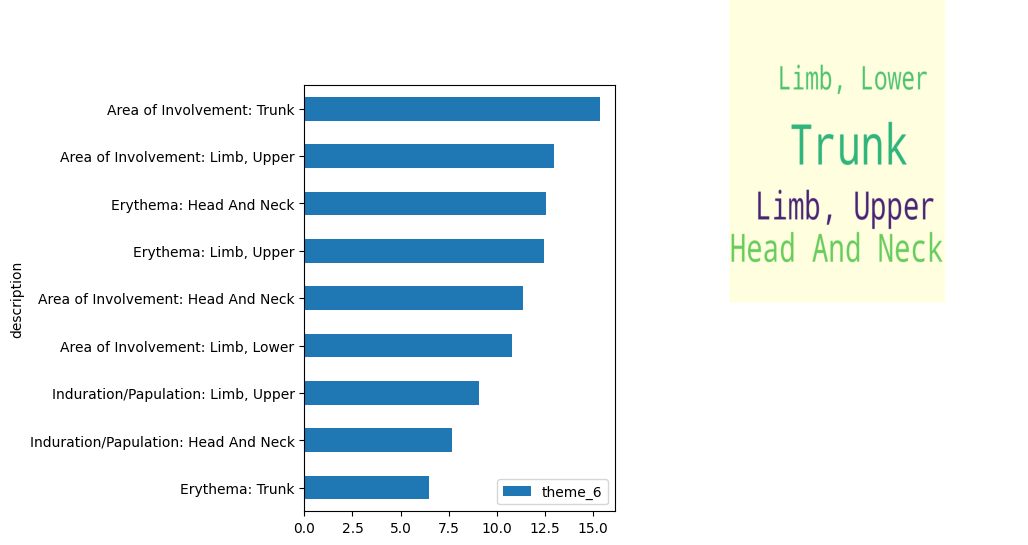

In [9]:
# Plot horizontal bar charts of the themes
for i in range(0,n_themes):
# for i in range(0,1):
    # plot the horizontal bar chart with ordered values
    df_temp = df_h4_updated_sparse[['description','theme_'+str(i+1)]].sort_values(by='theme_'+str(i+1), ascending=False).iloc[0:hhii_updated[i],:]
    df_temp.plot.barh(x='description', y='theme_'+str(i+1))
    fig_name=RESULTS_PATH + r'\theme_' + str(i+1) + '.png'
    plt.tight_layout()
    ax = plt.gca() # get the current axes object
    ax.invert_yaxis() # invert the y-axis
    # fig = plt.gcf()

    # Insert word cloud
    img = image.imread(RESULTS_PATH + r'\word_clouds_surveys_theme '+str(i+1)+'.png')
    # create a new axis for the image
    # ax = plt.gca()
    newax = ax.inset_axes([1.1, 0.25, 1.2, 1.2]) # adjust the position and size of the image
    newax.imshow(img)
    newax.axis("off") # turn off the axis

    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# Plot individual word clouds of the survey items

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated[df_h4_updated.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_items_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

In [ ]:
# Plot horizontal bar charts of q4
for i in range(0,n_themes):
    # plot the horizontal bar chart with ordered values
    # df_temp = df_q4[['score','theme_'+str(i+1)]].sort_values(by='theme_'+str(i+1), ascending=False)
    df_temp = df_q4_ism[['score','theme_'+str(i+1)]]
    df_temp.plot.barh(x='score', y='theme_'+str(i+1))
    fig_name=RESULTS_PATH + r'\score_' + str(i+1) + '.png'
    plt.tight_layout()
    ax = plt.gca() # get the current axes object
    ax.invert_yaxis() # invert the y-axis
    # fig = plt.gcf()
    plt.savefig(fig_name, dpi=300)
    plt.show()


Plot interaction network

In [ ]:
weight_cutoff = .6
show_edge_cutoff = .6

rows_with_nonzeros = np.where(np.amax(h4_updated_sparse, axis=1) > 0)[0]

list_network_items = [list_columns[i] for i in rows_with_nonzeros]
list_themes = ['Theme '+str(i) for i in range(1, n_themes+1)]

# create a new list of lists with items that start with each search sequence
new_list = [[item for item in list_network_items if item.endswith(seq)] for seq in score_pref]

# get the number of items in each sublist
n_network_items = [len(sublist) for sublist in new_list]
row_labels = list_themes+ list_network_items + score_pref
influence_matrix = np.vstack((h4_ism, h4_updated_sparse[rows_with_nonzeros], q4_ism)) @ w4_ism.T

weight = np.corrcoef(influence_matrix)

# Define a color map
node_colors = []
for i in range(0, len(row_labels)):
    if i < len(list_themes):
        node_colors.append('lightyellow')
    elif i < len(list_themes)+n_network_items[0]:
        node_colors.append('lightgreen')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]:
        node_colors.append('lightblue')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]:
        node_colors.append('orange')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]+n_network_items[3]:
        node_colors.append('red')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]+n_network_items[3]+len(score_pref):
        node_colors.append('yellow')

G = nx.Graph()
G.add_nodes_from(row_labels)

for i in range(len(row_labels)):
    for j in range(i + 1, len(row_labels)):
        if np.abs(weight[i][j]) > weight_cutoff:
            G.add_edge(row_labels[i], row_labels[j], weight=np.round(weight[i][j],2))

weights = nx.get_edge_attributes(G, 'weight')
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['weight']) > show_edge_cutoff]

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, iterations=200)
nx.draw_networkx_nodes(G, pos, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=[.25*weights[edge] for edge in elarge])

# nx.draw_networkx_labels(G, pos)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [score_pref[0]]}, font_size=16, font_weight='bold', font_color='grey', bbox=dict(facecolor='lightgreen', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [score_pref[1]]}, font_size=16, font_weight='bold', font_color='grey', bbox=dict(facecolor='lightblue', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [score_pref[2]]}, font_size=16, font_weight='bold', font_color='grey', bbox=dict(facecolor='orange', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [score_pref[3]]}, font_size=16, font_weight='bold', font_color='grey', bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))
   
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in list_themes}, font_size=16, font_weight='bold', font_color='grey', bbox=dict(facecolor='lightyellow', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node not in score_pref and node not in list_themes})

fig_name=RESULTS_PATH + r'\interaction_network.png'
plt.title('Interaction network')
plt.savefig(fig_name, dpi=300)
plt.show()

Plot interaction network including patients

In [ ]:
weight_cutoff = .6
show_edge_cutoff = 1

list_themes = ['Theme '+str(i) for i in range(1, n_themes+1)]

# Sort the DataFrame based on 'nmf_cluster' in ascending order and 'nmf_cluster_loading' in descending order
df_w4_ism = df_w4_ism.sort_values(['nmf_cluster', 'nmf_cluster_loading'], ascending=[True, False])
w4_ism_ordered = df_w4_ism[['theme_' + str(i) for i in range(1, n_themes + 1)]].values
w4_nmf_cluster = df_w4_ism[['nmf_cluster']].values

list_network_items = df_w4_ism.index.values.tolist()
# get the number of observations in each nmf cluster
unique_values, n_network_items = np.unique(w4_nmf_cluster, return_counts=True)

row_labels = list_themes + list_network_items
influence_matrix = np.vstack((h4_ism, w4_ism_ordered)) @ w4_ism.T

# save influence_matrix
df_influence_matrix = pd.DataFrame(influence_matrix)
df_influence_matrix.columns = df.index.to_list()
df_influence_matrix['nmf_cluster'] = np.vstack((np.zeros((len(list_themes),1)), w4_nmf_cluster))
df_influence_matrix.insert(loc=0, column='wise_id', value=(row_labels))
df_influence_matrix.set_index('wise_id')
df_influence_matrix.to_csv(RESULTS_PATH + r'\influence_matrix.csv', sep=',', na_rep='.',index=True)

weight = np.corrcoef(influence_matrix)

# Define a color map
node_colors = []
for i in range(0, len(row_labels)):
    if i < len(list_themes):
        node_colors.append('lightyellow')
    elif i < len(list_themes)+n_network_items[0]:
        node_colors.append('green')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]:
        node_colors.append('magenta')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]:
        node_colors.append('orange')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]+n_network_items[3]:
        node_colors.append('red')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]+n_network_items[3]+n_network_items[4]:
        node_colors.append('brown')
    elif i < len(list_themes)+n_network_items[0]+n_network_items[1]+n_network_items[2]+n_network_items[3]+n_network_items[4]+n_network_items[5]:
        node_colors.append('indigo')

G = nx.Graph()
G.add_nodes_from(row_labels)

for i in range(len(row_labels)):
    for j in range(i + 1, len(row_labels)):
        if np.abs(weight[i][j]) > weight_cutoff:
            G.add_edge(row_labels[i], row_labels[j], weight=np.round(weight[i][j],2))

weights = nx.get_edge_attributes(G, 'weight')
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['weight']) > show_edge_cutoff]

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, iterations=200)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=[10 for node in G.nodes()])
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=[.25*weights[edge] for edge in elarge])

   
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [list_themes[0]]}, font_size=16, font_weight='bold', font_color='lightgrey', bbox=dict(facecolor='green', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [list_themes[1]]}, font_size=16, font_weight='bold', font_color='lightgrey', bbox=dict(facecolor='magenta', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [list_themes[2]]}, font_size=16, font_weight='bold', font_color='lightgrey', bbox=dict(facecolor='orange', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [list_themes[3]]}, font_size=16, font_weight='bold', font_color='lightgrey', bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [list_themes[4]]}, font_size=16, font_weight='bold', font_color='lightgrey', bbox=dict(facecolor='brown', edgecolor='none', boxstyle='round,pad=0.2'))
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node in [list_themes[5]]}, font_size=16, font_weight='bold', font_color='lightgrey', bbox=dict(facecolor='indigo', edgecolor='none', boxstyle='round,pad=0.2'))

fig_name=RESULTS_PATH + r'\interaction_network_patients.png'
plt.title('Interaction network')
plt.savefig(fig_name, dpi=300)
plt.show()